In [1]:
#General Import Packages: 
#Plotting
from matplotlib import pyplot as plt
from matplotlib import colors, cm
from matplotlib.collections import LineCollection
import seaborn as sns
import trackpy as tp
import matplotlib.patches as patch

#Numerics, model implementation, path management, extras: 
import numpy as np
import pandas as pd
from pathlib import Path
import random as rand
from tqdm import tqdm 
from scipy.special import erfc

#Signal Analysis Functions: 
from scipy.signal import savgol_filter
from scipy.signal import peak_widths
from scipy.optimize import curve_fit


In [2]:
#Importing the relevant data frames is done using the following structure: 

#Set the base path as the root for an analysis set, all sets are arranged where images and analysis outputs are in the following locations: 
#base_path = Path('/media/echo/Samsung_T5/Main Data/Analysis Sets/23 Protofigures/Data Sets/2023_01_24_main-set')
base_path = Path.cwd().parent / 'Data Sets/2023_01_24_main-set'
images_folder = base_path / 'images'
analysis_output_destination = base_path / 'wavefit_outputs'

#There are three important dataframes used in analysis, the wave data frame, the ARCOS df, and the tracking df with binnned calcium values:
#The tracking is the most broad, followed by ARCOS and then the wave (most abstracted info):
wave_dataframe_paths = sorted(analysis_output_destination.glob('*_wave_df.csv'), key=lambda x: x.stem.split('_')[0])
arcos_dataframe_paths = sorted(analysis_output_destination.glob('*_ARCOS_df.csv'), key=lambda x: x.stem.split('_')[0])
tracking_dataframe_paths = sorted(analysis_output_destination.glob('*_tracking_binned_df.csv'), key=lambda x:x.stem.split('_')[0])


In [3]:
#Custom function to read in centroid arrays into dataframe instead of as a string: 
def read_tuple_list(x):
    x_strip = x.strip('()').strip('[]')
    if len(x_strip.split(', ')) == 1:
        return np.array(x_strip.split(), dtype=float)
    else:
        return np.array(x_strip.split(', '), dtype=float)

In [4]:
def consolidate_waves(WAVE_DF_PATHS, save_DF = False):
    
    wave_collect = []

    for wave_df_path in tqdm(WAVE_DF_PATHS):
        img_id = int(wave_df_path.stem.split('_')[0]) #Get the image ID to match to the wave:
        wave_df = pd.read_csv(wave_df_path, converters={"wave_centroid": read_tuple_list}) #Open the wave_DF from step4 analysis
        wave_df = wave_df[wave_df.columns.drop(list(wave_df.filter(regex='Unnamed')))] #Strip it of any weird unnamed index columns
        track_ids = wave_df['clTrackID'].values #Get the collective track values in the wave
        wave_df['wave_ID'] = [str(img_id) + '-' + str(i) for i in track_ids] #Build a list of unique wave IDs from the image number and clTrack number they belong to
        wave_df['image_ID'] = [img_id for i in range(len(wave_df))]
        wave_collect.append(wave_df)
    
    wave_df_collected = pd.concat(wave_collect, ignore_index=True)
    
    if save_DF:
        wave_df_collected.to_csv(WAVE_DF_PATHS[0].parent / 'combined_wave_DF.csv', index=False)
        
    return wave_df_collected

In [5]:
wave_con_df = consolidate_waves(wave_dataframe_paths)

100%|████████████████████████████████████████████| 57/57 [00:00<00:00, 706.84it/s]


/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

<Axes: xlabel='rel_time', ylabel='r_squared'>

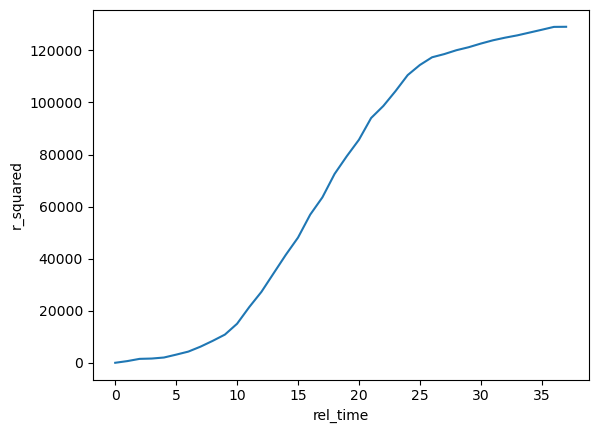

In [6]:
sns.lineplot(data = wave_con_df[wave_con_df.wave_ID == '49-19'], x='rel_time', y='r_squared')

In [7]:
wave_con_df[wave_con_df.wave_ID == '49-19'].rel_time.values*5.0

array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
        55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.,
       110., 115., 120., 125., 130., 135., 140., 145., 150., 155., 160.,
       165., 170., 175., 180., 185.])

In [8]:
wave_con_df[wave_con_df.wave_ID == '49-19'].r_squared.values

array([     0.        ,    652.3903751 ,   1504.15181031,   1629.34077043,
         2024.20226649,   3127.57430273,   4296.14423817,   6197.18847584,
         8425.26369935,  10827.7688865 ,  14996.92468616,  21408.90944027,
        27263.52359469,  34388.95069267,  41487.90825463,  48098.73841293,
        56912.7512542 ,  63545.76253556,  72548.72842657,  79349.29640843,
        85686.76706147,  94042.4033674 ,  98652.99618929, 104365.11011299,
       110527.00198908, 114406.76787636, 117365.14543429, 118591.11650954,
       120082.55315424, 121224.80498612, 122629.72566418, 123895.33949133,
       124908.6664619 , 125791.44142316, 126862.56671223, 127938.40591212,
       129039.61989356, 129082.27832996])

In [7]:
trackable_waves = wave_con_df[wave_con_df['trackable']==True]

In [8]:
wave_bin = []

for wid, wave in trackable_waves.groupby('wave_ID'):
    if wave.rel_r.max() > 300:
        wave_bin.append(wave)
binned_track_waves = pd.concat(wave_bin)
binned_track_waves['real_time'] = 5.0*binned_track_waves['rel_time']

In [18]:
#relay_output = pd.read_csv('/media/echo/Samsung_T5/Main Data/Analysis Sets/23 Protofigures/Fig3 - Model vs Data Stop/model/simple_relay_output.csv')
relay_output = pd.read_csv(Path.cwd().parent / 'Fig2 - Wave kinetics/diffusion relay compare/fits/full_relay_fit.csv')
relay_output['r_2'] = (relay_output['r_relay'] - 15)**2

In [22]:
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5, 'font.family': ['arial'], 'axes.linewidth':2})

/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

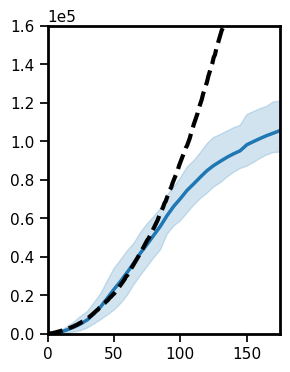

In [27]:
plt.figure(figsize=(3,4))
sns.lineplot(data=relay_output, x='time', y='r_2', linestyle='--', color = 'k', linewidth=3)
sns.lineplot(data=binned_track_waves, x='real_time', y='r_squared', zorder=-1)
plt.xlim(0,175)
plt.ylim(0,160000)
plt.xlabel('')
plt.ylabel('')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig('fig3a_simple-relay-v-data.png', dpi=300, bbox_inches='tight')

In [24]:
data_ts = []
data_rs = []

for t, timepoint in binned_track_waves.groupby('real_time'):
    data_ts.append(t)
    data_rs.append(timepoint.circle_radius.mean())

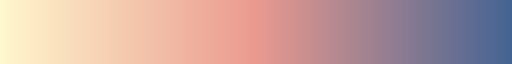

In [15]:
colors.LinearSegmentedColormap.from_list(colors=['#fff7cd','#ea9a8f', '#456493'], name='lbupu')

In [21]:
normed = colors.Normalize(vmin=30, vmax=100)
#cmap_vals = sns.color_palette("Set3", as_cmap=True)
cmap_vals = colors.LinearSegmentedColormap.from_list(colors=['#fff7cd','#ea9a8f', '#456493'], name='lbupu')

In [27]:


final_ts = range(0,65,6)

for final_t in final_ts: 

    fig, ax = plt.subplots(figsize=(4,4))
    r_vals = data_rs[:final_t]

    for i,r_val in enumerate(r_vals):
        if i%5 == 0:
            c = patch.Circle((0,0), r_val, fill=False, edgecolor=cmap_vals(normed(data_ts[i])), linewidth=6)
            #print(data_ts[i])
            ax.add_patch(c)
        
    plt.xlim(-500,500)
    plt.ylim(-500,500)



    filename = "/Volumes/Samsung_T5/Main Data/Analysis Sets/23 Protofigures/Fig3 - Model vs Data Stop/fig3a_still_outputs/largest_waves_mean_t-" + str(int(data_ts[final_t])) + ".png"
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.close()

In [23]:
#final_ts = range(1,301,step=100)

#ts = 0.005:0.005:1.51
#r = [wave_front_r(LTB4_ROS_2d3d_sol_1(t)[:,1], rd_LTB4 , 50, 0.1) for t in ts]

#cmap_vals = sns.color_palette("BuPu",120)

final_ts = range(0,175,25)
t_vals = relay_output['time'].values

for final_t in final_ts: 

    fig, ax = plt.subplots(figsize=(4,4))
    r_vals = relay_output['radius'].values[:final_t]

    for i,r_val in enumerate(r_vals):
        if i%25 == 0:
            c = patch.Circle((0,0), r_val, fill=False, edgecolor=cmap_vals(normed(t_vals[i])), linewidth=6)
            #print(t_vals[i])
            ax.add_patch(c)
        
    plt.xlim(-500,500)
    plt.ylim(-500,500)



    filename = "/Volumes/Samsung_T5/Main Data/Analysis Sets/23 Protofigures/Fig3 - Model vs Data Stop/fig3a_still_outputs/simple_realy_circles_t-" + str(int(t_vals[final_t])) + ".png"
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.close()
